In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots

torch.manual_seed(40)

plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300

In [ ]:
from src.inference.prior import get_prior
from src.inference.simulator import create_simulator

prior = get_prior()
simulator = create_simulator()

c:\Users\Julian\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
from src.inference.utils import load_model

density_estimator = load_model(os.path.join("..", "results", "inference", "trained_model_4.pkl")) # Esta inferencia se hizo usando una CNN, con 10000 sims y con lensing=False

In [4]:
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.inference import SNPE_C

embedding_net = CNNEmbedding(
    input_shape=(2401,),             
    in_channels=1,                   
    out_channels_per_layer=[16, 32, 64],  
    num_conv_layers=3,              
    num_linear_layers=2,           
    output_dim=8,                  
    kernel_size=5,                 
    pool_kernel_size=4             
)

neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

inference = SNPE_C(
    prior=prior,
    density_estimator=neural_posterior,
    device="cpu"
)

posterior = inference.build_posterior(density_estimator)
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [7]:
true_parameter = torch.tensor([[0.315, 0.049, 0.674, 0.811, 0.965, 0.054]])
x_observed = simulator(true_parameter)

torch.manual_seed(40)
samples = posterior.set_default_x(x_observed).sample((45000,))

Simulación 1/1 - Parámetros: [0.315 0.049 0.674 0.811 0.965 0.054]









Drawing 45000 posterior samples: 47565it [00:01, 38994.77it/s]


Drawing 50000 posterior samples:   0%|          | 0/50000 [01:44<?, ?it/s]


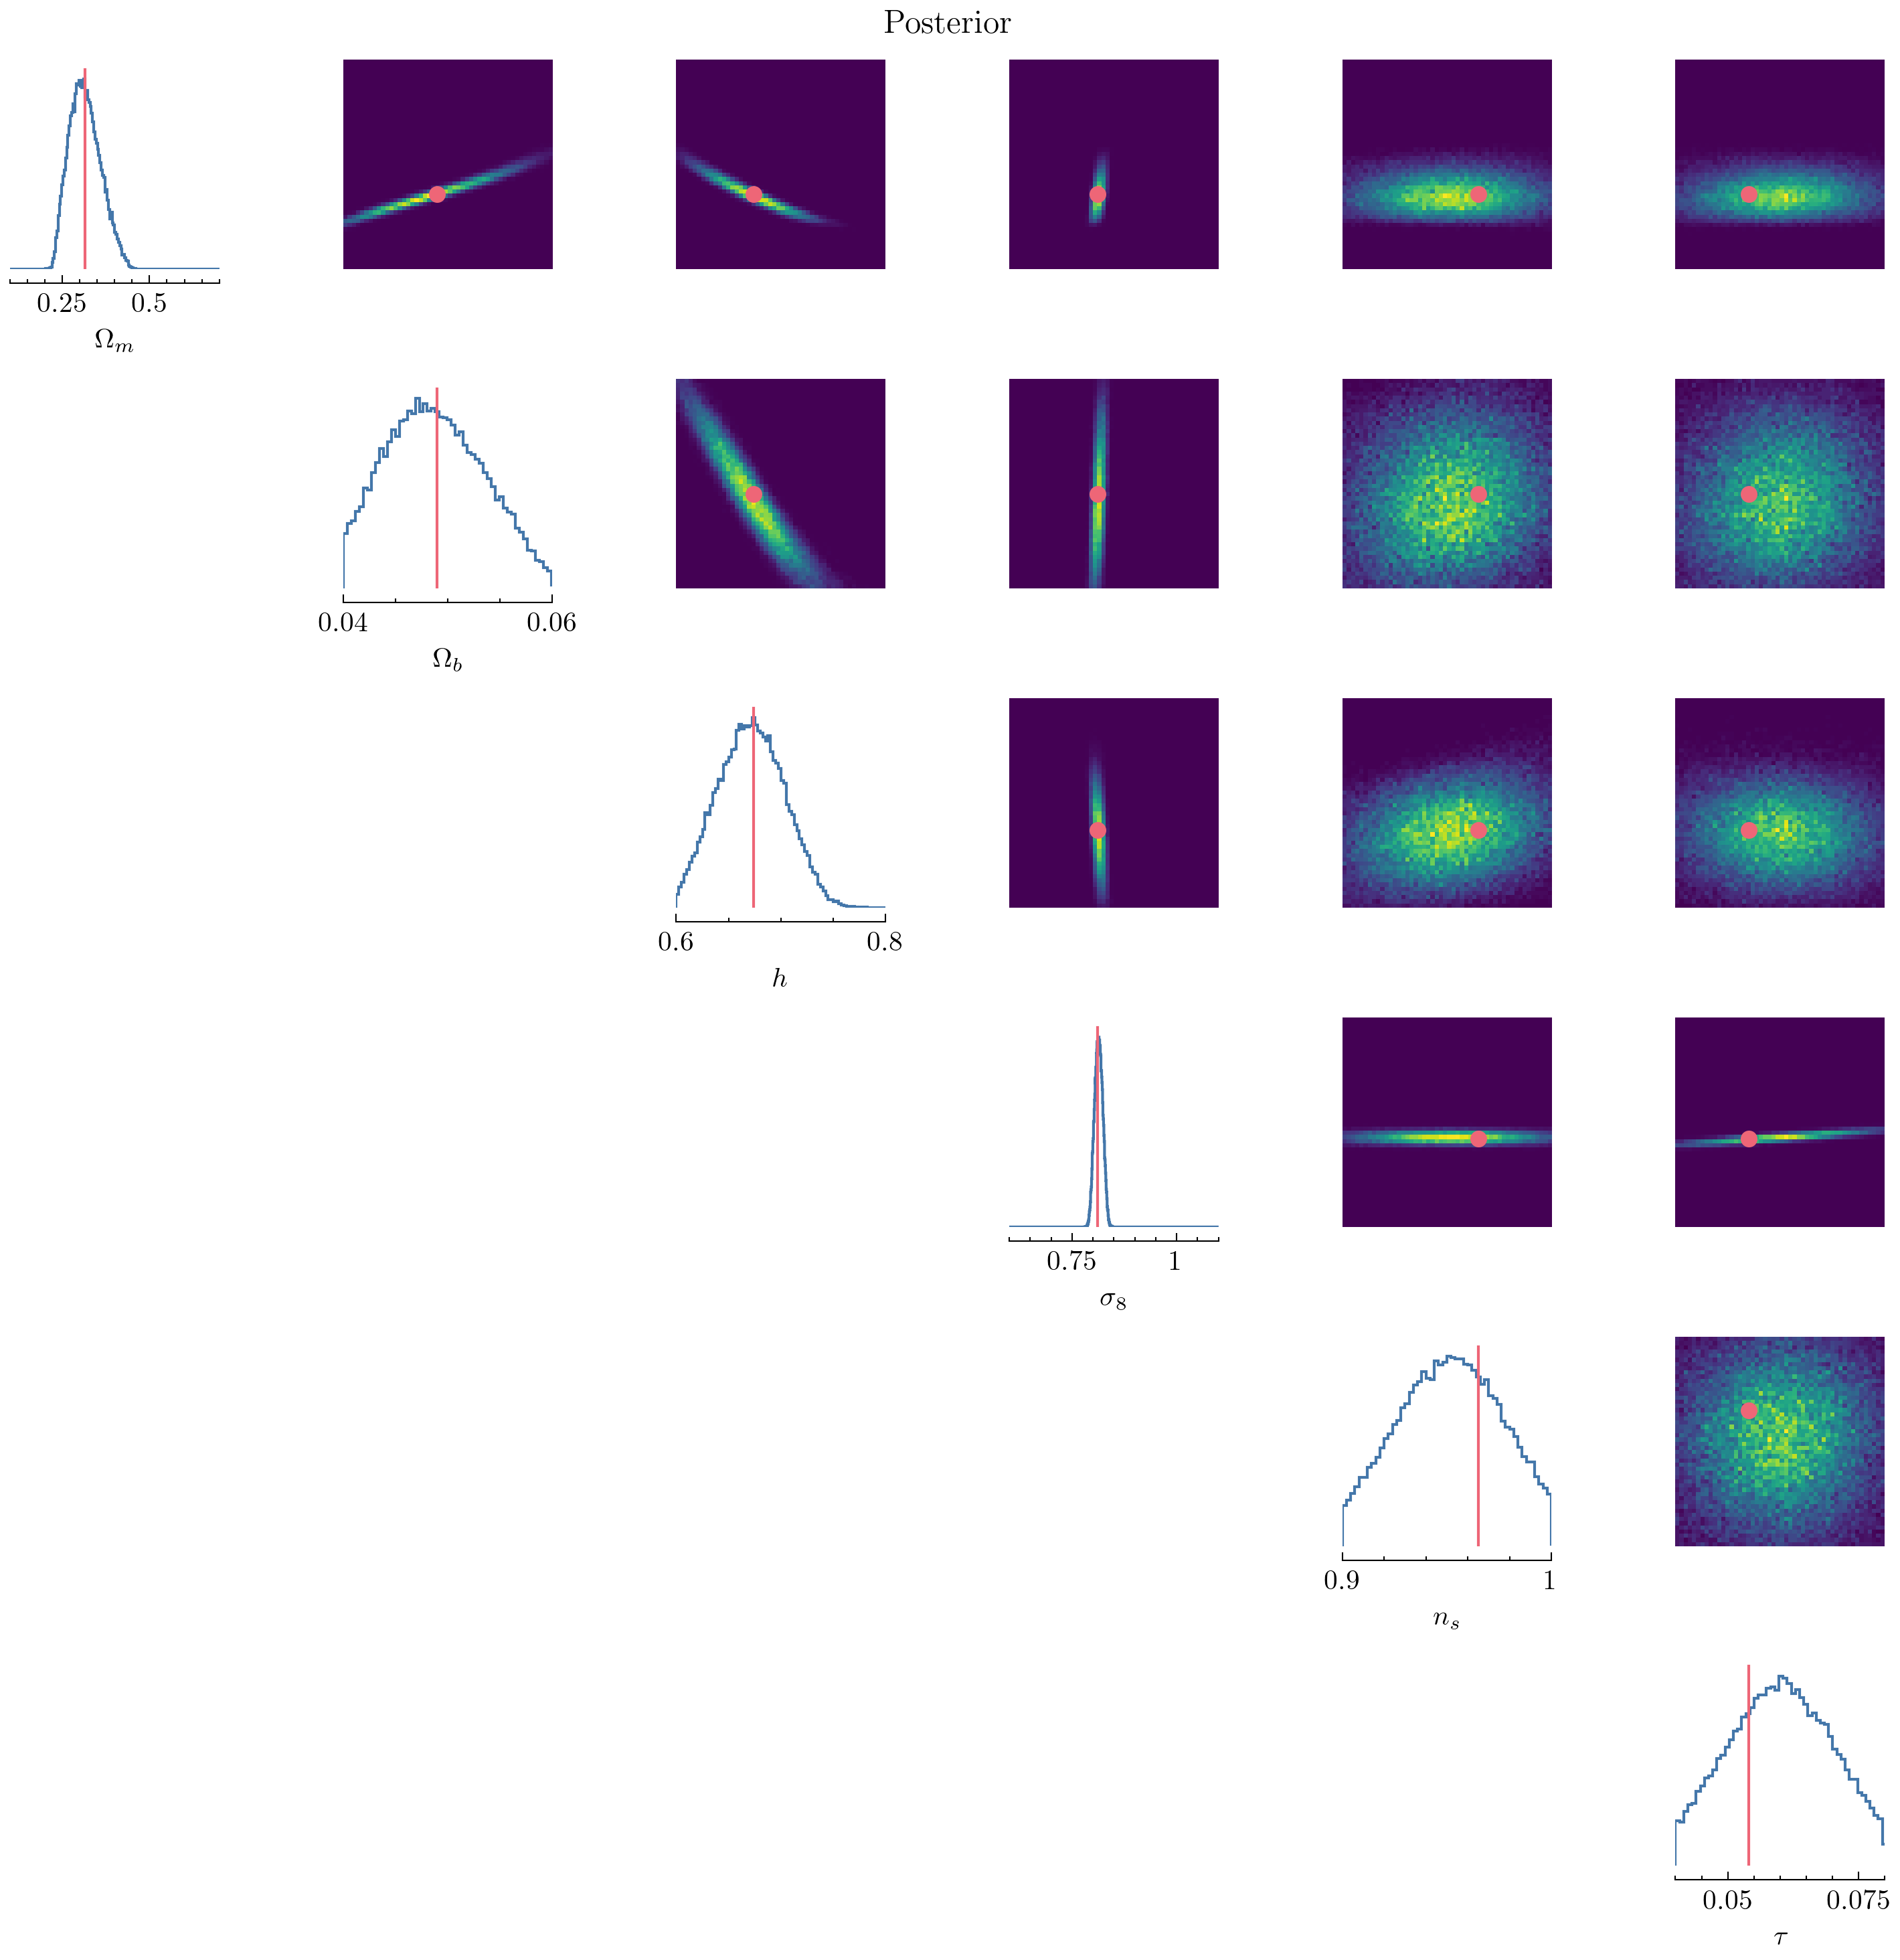

In [8]:
from sbi.analysis import pairplot

# --- LÍMITES DEL PRIOR ---
limits = torch.tensor([
    [0.1, 0.7],    
    [0.04, 0.06],  
    [0.6, 0.8],   
    [0.6, 1.1],    
    [0.9, 1.0],    
    [0.04, 0.08],  
])

param_names = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$\sigma_8$', r'$n_s$', r'$\tau$']

fig = pairplot(
    samples,
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

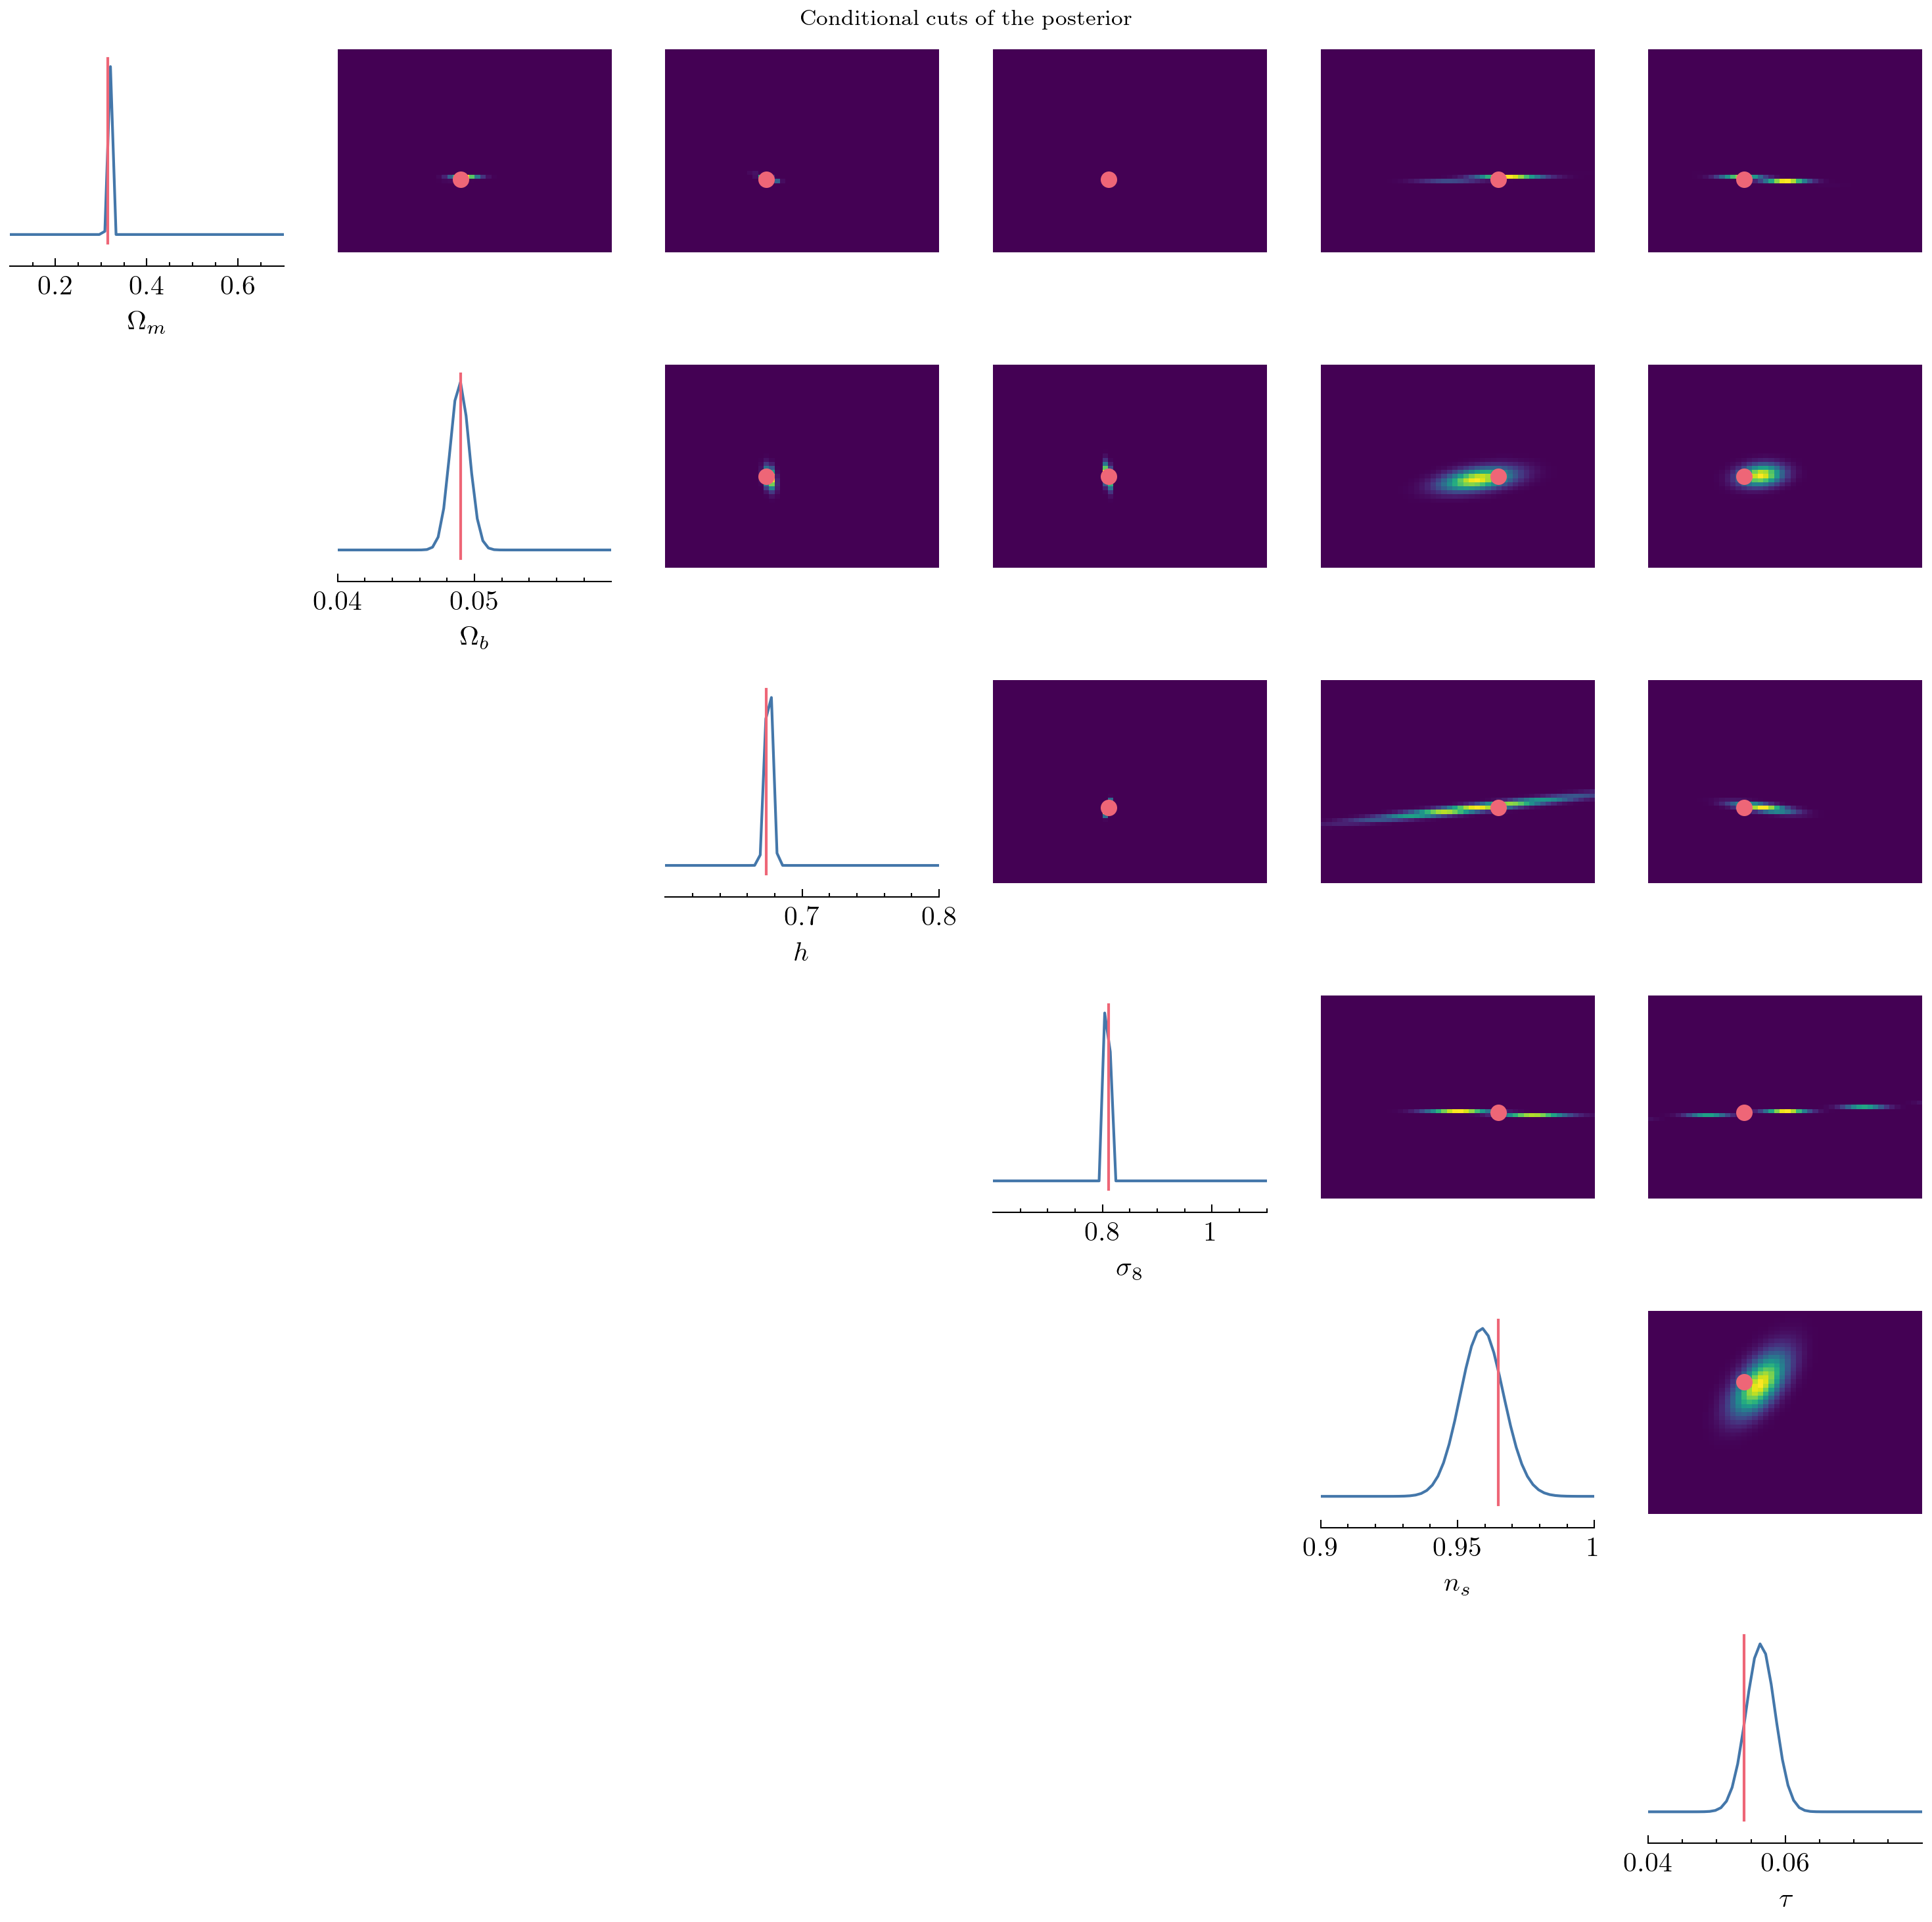

In [9]:
from sbi.analysis import conditional_pairplot

condition = true_parameter

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=limits,
    figsize=(10, 10),
    labels=param_names,
    points=true_parameter
)
plt.suptitle("Conditional cuts of the posterior", fontsize=8)
plt.tight_layout()
plt.show()